In [1]:
# 1 라이브러리 임포트

import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn as sk

# 알고리즘을 그래픽화 하기위한 라이브러리
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import rcParams
import re
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras

# 모델생성 라이브러리
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 데이터 스플릿,스케일링
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [2]:
# 1. 경로 지정과 임포트하기
path = ("./playground-series-s3e2/")

df_train = pd.read_csv(path+"train.csv")
df_test = pd.read_csv(path+"test.csv")

# 1-1 겟더미로 문자열 제거 
df_train = pd.get_dummies(df_train)
df_test  = pd.get_dummies(df_test)


In [13]:
# 2. 데이터 조회
print(df_train.shape)
# print(df_train.head())

(15304, 23)


In [14]:
# 3.널값 확인
df_train.isna().sum()
# df_train.isnull().any()
# 아에 널값이 없는 정제된 데이터를 확인.. ㄷㄷ

id                                0
age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
stroke                            0
gender_Female                     0
gender_Male                       0
gender_Other                      0
ever_married_No                   0
ever_married_Yes                  0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
Residence_type_Rural              0
Residence_type_Urban              0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [15]:
# 4. 데이터 전처리 
# 데이터 스플릿과 스케일링 할꺼임 
# 결측치가 없어서 결측치 처리는 안해도됨

# 4-1 데이터를 x와 y 로 분할
x = df_train.drop(["stroke"],axis=1)
y = df_train["stroke"]
x = x.drop(["id"],axis=1)
# y = y.drop(["id"],axis=1)
print(x.shape,y.shape)

(15304, 21) (15304,)


0    0
1    0
2    0
3    0
4    0
Name: stroke, dtype: int64

In [6]:
# 4-2 테스트 데이터와 훈련 데이터로 스플릿

x_train, x_test, y_train,y_test = train_test_split(
    x,
    y,
    train_size=0.8,
    shuffle = True,
    stratify = y,
    # random_state=21
)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(12243, 21) (3061, 21)
(12243,) (3061,)


In [7]:
# 4-3 문자열 겟더미로 인덱싱
# df_train = pd.get_dummies(df_train, columns=["gender","ever_married","work_type","Residence_type","smoking_status"],\
#                           prefix=["gender","ever_married","work_type","Residence_type","smoking_status"], drop_first=True)
# df_test = pd.get_dummies(df_test, columns=["gender","ever_married","work_type","Residence_type","smoking_status"],\
#                           prefix=["gender","ever_married","work_type","Residence_type","smoking_status"], drop_first=True)


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15304 non-null  int64  
 1   age                             15304 non-null  float64
 2   hypertension                    15304 non-null  int64  
 3   heart_disease                   15304 non-null  int64  
 4   avg_glucose_level               15304 non-null  float64
 5   bmi                             15304 non-null  float64
 6   stroke                          15304 non-null  int64  
 7   gender_Female                   15304 non-null  uint8  
 8   gender_Male                     15304 non-null  uint8  
 9   gender_Other                    15304 non-null  uint8  
 10  ever_married_No                 15304 non-null  uint8  
 11  ever_married_Yes                15304 non-null  uint8  
 12  work_type_Govt_job              

In [9]:
# 4-3 데이터스케일링

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


In [10]:
print(x_train.shape,y_train.shape)

(12243, 21) (12243,)


In [16]:
# 5 모델구성

dr = 0.1
model = Sequential([
    Dense(256,input_dim=21,activation="relu"),
    Dropout(rate=dr),
    Dense(128,activation="relu"),
    Dropout(rate=dr),
    Dense(64,activation="relu"),
    Dropout(rate=dr),
    Dense(32,activation="relu"),
    Dropout(rate=dr),
    Dense(16,activation="relu"),
    Dropout(rate=dr),
    Dense(8,activation="relu"),
    Dropout(rate=dr),
    Dense(4,activation="relu"),
    Dropout(rate=dr),
    Dense(2,activation="relu"),
    Dropout(rate=dr),
# 이진분할 이기때문에 출력층 1 , sigmoid
    Dense(1,activation="sigmoid")
])


In [18]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stopping = EarlyStopping(
monitor='val_loss',
mode='min',
patience=30, 
min_delta=0.0001,
verbose=1, 
)

plat =ReduceLROnPlateau(
        monitor="val_loss", 
        mode='min', 
        patience=3, 
        factor=0.1, 
        min_lr=1e-8, 
        min_delta=0.000001)

model.compile(loss="binary_crossentropy",optimizer="adam",metrics = ['mean_absolute_error',tf.keras.metrics.RootMeanSquaredError()])

hist = model.fit(x_train, y_train, epochs=500, 
                 validation_split=0.2,
                 batch_size=128, 
                 verbose=1,
                 callbacks = [early_stopping,plat])


Epoch 1/500
154/154 [==============================] - 1s 5ms/step - loss: 0.1506 - accuracy: 0.9599 - val_loss: 0.1400 - val_accuracy: 0.9539 - lr: 0.0010
Epoch 2/500
154/154 [==============================] - 1s 4ms/step - loss: 0.1491 - accuracy: 0.9599 - val_loss: 0.1428 - val_accuracy: 0.9539 - lr: 0.0010
Epoch 3/500
154/154 [==============================] - 1s 4ms/step - loss: 0.1426 - accuracy: 0.9599 - val_loss: 0.1376 - val_accuracy: 0.9539 - lr: 0.0010
Epoch 4/500
154/154 [==============================] - 1s 3ms/step - loss: 0.1402 - accuracy: 0.9599 - val_loss: 0.1367 - val_accuracy: 0.9539 - lr: 0.0010
Epoch 5/500
154/154 [==============================] - 1s 4ms/step - loss: 0.1409 - accuracy: 0.9599 - val_loss: 0.1391 - val_accuracy: 0.9539 - lr: 0.0010
Epoch 6/500
154/154 [==============================] - 1s 4ms/step - loss: 0.1401 - accuracy: 0.9599 - val_loss: 0.1396 - val_accuracy: 0.9539 - lr: 0.0010
Epoch 7/500
154/154 [==============================] - 1s 4ms/st

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(x_train, y_train, batch_size=30)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

409/409 [==============================] - 1s 2ms/step - loss: 0.1290 - accuracy: 0.9587
accuracy: 95.87%


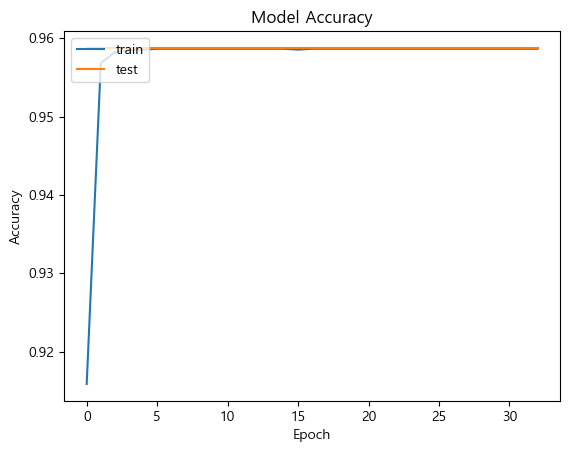

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

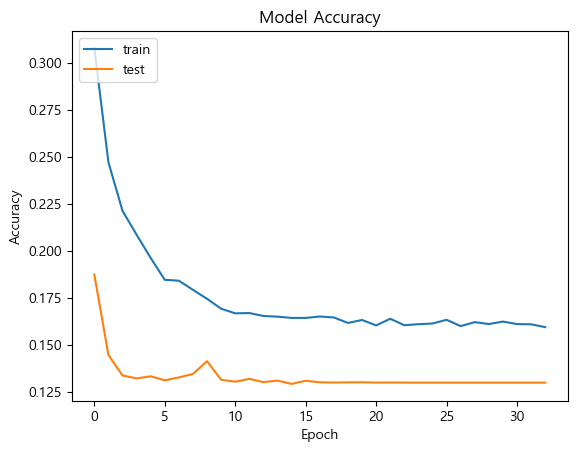

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
df_test = pd.DataFrame(df_test)
df_test = df_test.drop(["id"],axis=1)
df_test.shape

(10204, 21)

In [ ]:

y_submit = model.predict(df_test)
print(y_submit[:20])

# 1 과 1로 이진변환해주는 코드
y_submit =y_submit.flatten()
# y_predict 가 0.5 보다 크면 1 아니면 0 반환
y_submit = np.where(y_submit > 0.5, 1 , 0)
print(y_submit[:20])


[[0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]
 [0.29135892]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
preds =[]

preds.append(model.predict(df_test))
pred = np.average(np.array(preds),axis=0)

pred

# 15-3 경로와 파일명 지정
submission = pd.read_csv(path +"sample_submission.csv",index_col="id")
submission['stroke'] = pred
submission['stroke'] = submission['stroke'].clip(0,1)
submission

stroke
id             
15304  0.291359
15305  0.291359
15306  0.291359
15307  0.291359
15308  0.291359
...         ...
25503  0.291359
25504  0.291359
25505  0.291359
25506  0.291359
25507  0.291359

[10204 rows x 1 columns]

In [ ]:
# 15-2.제촐용을 데이터프레임형으로 변환
submission = pd.read_csv(path +"sample_submission.csv",index_col="id")

# 15-2 제출용의 카운트 칼럼에 y_submit 삽입
submission["stroke"] = y_submit.astype(int)
# 15-3 경로와 파일명 지정
submission.to_csv(path + "submission_3.csv")


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))
# 평가 손실률 가져오기
loss = model.evaluate(x_test,y_test)

y_predict =model.predict(x_test)
# print("=================")
# print(y_test)
# print(y_predict)
print("================================")
print("loss : ",loss[0],"\n acc : ",loss[1])
print("RMSE : ",RMSE(y_test,y_predict))
print("R2   : ",r2_score(y_test,y_predict))

96/96 [==============================] - 0s 2ms/step - loss: 0.1336 - accuracy: 0.9588
loss :  0.13361206650733948 
 acc :  0.9588369727134705
RMSE :  0.1883381541525112
R2   :  0.10127954187530863
